# Custom Tabulation Example: 4D Coal Combustion Model

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_

_Highlights_

- building a table with user-defined continuation loops
- varying the fuel stream and incorporating nonadiabatic effects in a quasisteady manner
- stacking contour plots to visualize a 3D field

This example showcases a flamelet library built with manual loops over the tabulation dimensions. We build a four-dimensional table of states over the mixture fraction, scalar dissipation rate (stoichiometric value), heat transfer coefficient, and fraction of volatiles and char (from coal particle gasification) in the fuel stream. The heat transfer dimension is expanded in a quasisteady manner, with steady states calcalated at each heat transfer coefficient (or, at each enthalpy defect), as an alternative to transient heat loss calculations in the provided `build_nonadiabatic_defect_transient_slfm_library` method (but very similar to the `build_nonadiabatic_defect_steady_slfm_library` method).

Here we manually loop over table dimensions and use the `Flamelet` class directly instead of the higher-level convenience methods provided in the `spitfire.chemistry.tabulation` module. While the tabulation methods are much more convenient, this provides a finer level of control and customizability for tabulation techniques not currently wrapped in a high-level interface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import perf_counter
from spitfire import ChemicalMechanismSpec, Flamelet, FlameletSpec, Dimension, Library

First we define a helper function for mixing char and volatiles and load some stream data for later use.

In [2]:
def get_fuel_stream(coal_fuels, alpha, mechanism, pressure=101325.):
    """
    Fuel streams representative of coal combustion, spanning char to volatiles, with volatiles fraction alpha.
    Personal communication with Josh McConnell, University of Utah, 2018.
    """
    volatiles = mechanism.stream('TPY', (coal_fuels['volatiles']['T'], pressure, coal_fuels['volatiles']['Y']))
    char = mechanism.stream('TPY', (coal_fuels['char']['T'], pressure, coal_fuels['char']['Y']))
    return mechanism.mix_streams([(volatiles, alpha), (char, 1. - alpha)], 'mass', 'HP')

with open('coalflamelet_bcs.pkl', 'rb') as bcs_src:
    coal_fuels = pickle.load(bcs_src)

Next we load up a wrapper of the GRI-3.0 methane combustion mechanism and make an air stream.

In [3]:
mechanism = ChemicalMechanismSpec(cantera_input='methane-gri30.yaml', group_name='gri30_mix')

pressure = 101325.

oxy = mechanism.stream(stp_air=True)
oxy.TP = 350., pressure

Next we specify the table dimensions for the char/volatiles fraction, dissipation rate, heat transfer coefficient, and mixture fraction. From the set of values of each variable we make a `Library` object. Then for each property to be tabulated we set up an empty dataset in the library to fill later as we perform continuation across each library dimension.

In [4]:
mixfrac_vec = np.linspace(0., 1., 96)
alpha_vec = np.array([0.0, 0.1, 0.3, 0.5, 0.7])
chist_vec = np.logspace(-1., 3., 8)
h_vec = np.hstack([0., np.logspace(-8, 1, 24)])

zdim = Dimension('mixture_fraction', mixfrac_vec)
xdim = Dimension('dissipation_rate_stoich', chist_vec, log_scaled=True)
hdim = Dimension('heat_transfer_coefficient', h_vec)
adim = Dimension('alpha', alpha_vec)

l = Library(adim, hdim, xdim, zdim)
l.extra_attributes['mech_spec'] = mechanism

for q in ['temperature', 'pressure'] + ['mass fraction ' + s for s in mechanism.species_names]:
    l[q] = l.get_empty_dataset()

Now we make a specifications for the flamelet.

In [5]:
particle_temperature = 350.

flamelet_specs = {'mech_spec': mechanism,
                  'oxy_stream': oxy,
                  'fuel_stream': get_fuel_stream(coal_fuels, 0., mechanism, pressure),
                  'grid': mixfrac_vec,
                  'heat_transfer': 'nonadiabatic',
                  'convection_temperature': particle_temperature,
                  'convection_coefficient': 0.,
                  'scale_heat_loss_by_temp_range': False,
                  'scale_convection_by_dissipation': False,
                  'use_linear_ref_temp_profile': False,
                  'radiation_temperature': particle_temperature,
                  'radiative_emissivity': 0.,
                  'rates_sensitivity_type': 'sparse'}

Now we enter into the loops. In continuation calculations it is critical to get the best initial guess, as this determines convergence rates and often the solution that is ultimately computed. We treat different values of $\alpha$ (the char/volatiles fraction) as separate problems entirely, not using the solution from one value to inform the next, as the chemistry is so different between them given our coarse resolution of the $\alpha$ line.

For each $\alpha$, then, we build a three-dimensional library over the dissipation rate ($\chi_{\rm st}$), heat transfer coefficient ($h$), and mixture fraction ($\mathcal{Z}$). Note that each three-dimensional table could be generated in parallel with the `multiprocessing` module. A relevant approach to parallelization is taken in the `build_nonadiabatic_defect_*_slfm_library` methods in Spitfire. An annoyance that Cantera solution objects cannot be directly pickled (a form of serialization required by `multiprocessing`). However `ChemicalMechanismSpec` instances can be pickled and so incorporation of multiprocessing isn't too bad.

In building the three-dimensional library, we first iterate over serial calculations in the dissipation rate direction with zero heat loss (adiabatic flamelets), where each prior solution provides an excellent initial guess for the next dissipation rate. From this line of solutions, then, we have even more parallel work in the heat loss dimension, which may be solved for each dissipation rate independently of the others. Again, each extension of the heat loss dimension is treated serially, using the prior solution as the initial guess.

Here we do not exploit the available parallelism in any way to keep things simple, but factors of ten or more speedup could be easily obtained with a bit of extra work for either Python-based multiprocessing or simply running multiple scripts and combining the libraries after the fact.

In [6]:
flamelet_specs['initial_condition'] = 'equilibrium'
if 'library_slice' in flamelet_specs:
    flamelet_specs.pop('library_slice')

cput000 = perf_counter()
for ia, alpha in enumerate(alpha_vec):
    print(f'Running alpha = {alpha:4.2f} ...')
    flamelet_specs.update({'fuel_stream': get_fuel_stream(coal_fuels, alpha, mechanism)})
    
    adiabatic_solutions = list()
    cput00 = perf_counter()
    for ichi, chist in enumerate(chist_vec):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        if ichi > 0:
            flamelet_specs['library_slice'] = Library.squeeze(l[ia, 0, ichi - 1, :])
        else:
            if 'library_slice' in flamelet_specs:
                flamelet_specs.pop('library_slice')
        f = Flamelet(**flamelet_specs)
        steady_adiabatic_lib = f.compute_steady_state()
        for quantity in steady_adiabatic_lib.props:
            l[quantity][ia, 0, ichi, :] = steady_adiabatic_lib[quantity].ravel()
    cput1 = perf_counter()
    print(f'Converged adiabatic solutions in {cput1-cput00:6.2f} s {"":24} | total cpu time is {cput1 - cput000:6.2f} s')
    
    for ichi, chist in enumerate(chist_vec):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        cput0 = perf_counter()
        for ih, h in enumerate(h_vec):
            flamelet_specs.update({'convection_coefficient': h})
            flamelet_specs['library_slice'] = Library.squeeze(l[ia, ih - 1 if ih > 0 else 0, ichi, :])
            f = Flamelet(**flamelet_specs)
            output = f.compute_steady_state()
    
            for quantity in output.props:
                l[quantity][ia, ih, ichi, :] = output[quantity].ravel()
        cput1 = perf_counter()
        print(f'{"":9} heat loss solutions for chi_st = {chist:7.2e} Hz in {cput1-cput0:6.2f} s | {"":14} is {cput1 - cput000:6.2f} s')
    
    cput1 = perf_counter()
    print(f'Completed alpha = {alpha:4.2f} in {cput1-cput00:6.2f} s')
    print('-' * 95)

Running alpha = 0.00 ...


Converged adiabatic solutions in   4.35 s                          | total cpu time is   4.35 s
          heat loss solutions for chi_st = 1.00e-01 Hz in   3.87 s |                is   8.22 s
          heat loss solutions for chi_st = 3.73e-01 Hz in   1.02 s |                is   9.24 s
          heat loss solutions for chi_st = 1.39e+00 Hz in   0.92 s |                is  10.16 s
          heat loss solutions for chi_st = 5.18e+00 Hz in   1.41 s |                is  11.57 s
          heat loss solutions for chi_st = 1.93e+01 Hz in   0.89 s |                is  12.46 s
          heat loss solutions for chi_st = 7.20e+01 Hz in   0.87 s |                is  13.33 s
          heat loss solutions for chi_st = 2.68e+02 Hz in   1.02 s |                is  14.35 s
          heat loss solutions for chi_st = 1.00e+03 Hz in   0.76 s |                is  15.12 s
Completed alpha = 0.00 in  15.12 s
-----------------------------------------------------------------------------------------------
Runni

### Saving a library file for later use
Saving a library file to disk to be reloaded later is straightforward.

The rest of the notebook consists of some visualizations of the library data.

In [7]:
l.save_to_file('coal_library.pkl')
library = Library.load_from_file('coal_library.pkl')

In [8]:
z_dim = library.dim('mixture_fraction')
x_dim = library.dim('dissipation_rate_stoich')
h_dim = library.dim('heat_transfer_coefficient')
a_dim = library.dim('alpha')

Here are the adiabatic temperature profiles at minimium and moderate $\chi_{\rm st}$ for various mixtures of volatiles and char.

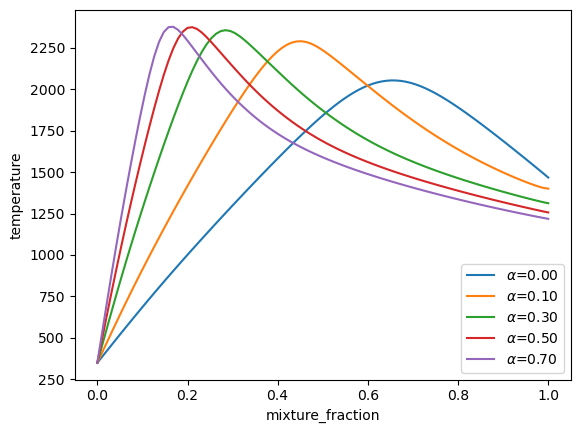

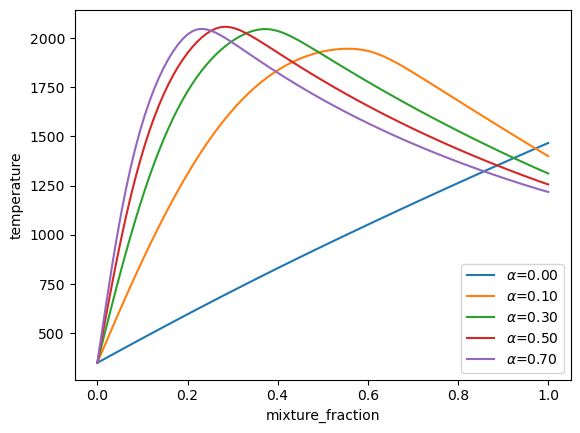

In [9]:
for ia, a in enumerate(a_dim.values):
    plt.plot(z_dim.values, library['temperature'][ia, 0, 0, :], label='$\\' + a_dim.name + '$' + f'={a:.2f}')
plt.legend(loc='best')
plt.xlabel(z_dim.name)
plt.ylabel('temperature')
plt.show()

for ia, a in enumerate(a_dim.values):
    plt.plot(z_dim.values, library['temperature'][ia, 0, 6, :], label='$\\' + a_dim.name + '$' + f'={a:.2f}')
plt.legend(loc='best')
plt.xlabel(z_dim.name)
plt.ylabel('temperature')
plt.show()

And here are some contour plots of adiabatic profiles over $(\mathcal{Z},\chi_{\rm st})$ for each $\alpha$ value. Note the effect of $\alpha$ on the availablity of acetylene, a key ingredient in soot formation.

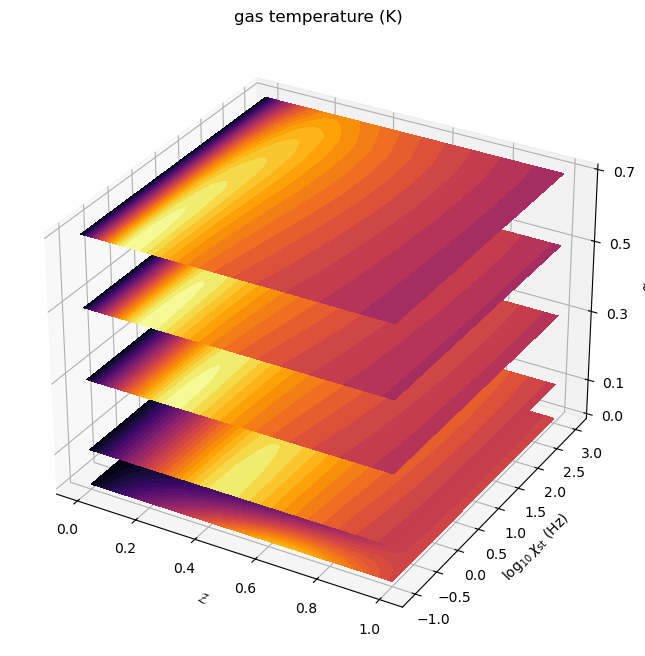

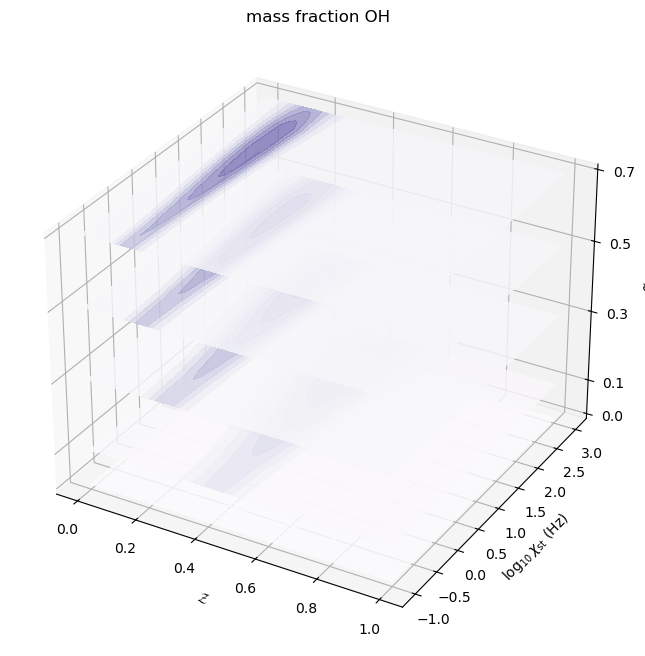

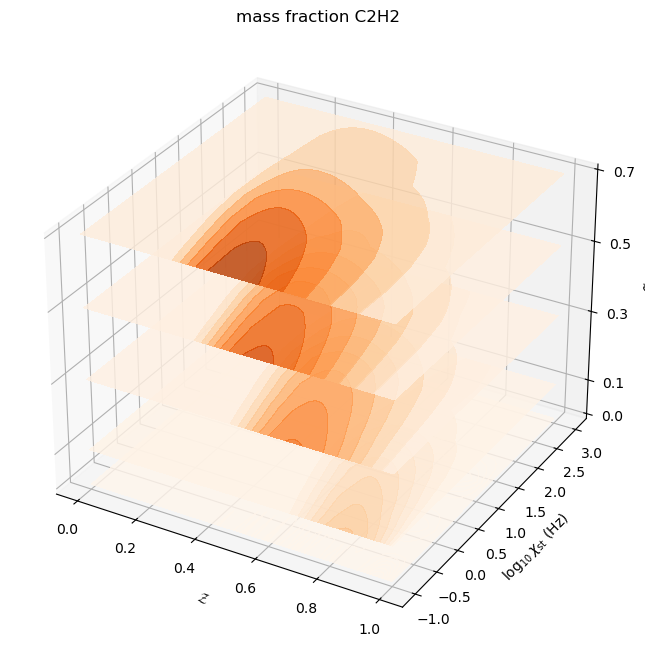

In [10]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import Normalize

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
z = library.mixture_fraction_grid[0, 0, :, :]
x = np.log10(library.dissipation_rate_stoich_grid[0, 0, :, :])
for ia, alpha in enumerate(adim.values):
    ax.contourf(z, x, l['temperature'][ia, 0, :, :], offset=alpha, 
                cmap='inferno', levels=30, norm=Normalize(vmin=300, vmax=2400))
ax.set_zlim([0, 0.7])
ax.set_xlabel('$\\mathcal{Z}$')
ax.set_ylabel('$\\log_{10}\\chi_{\\rm st}$ (Hz)')
ax.set_zlabel('$\\alpha$')
ax.set_zticks([0, 0.1, 0.3, 0.5, 0.7])
ax.set_title('gas temperature (K)')
fig.set_size_inches(8, 8)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for ia, alpha in enumerate(adim.values):
    ax.contourf(z, x, l['mass fraction OH'][ia, 0, :, :], offset=alpha, 
                cmap='Purples', norm=Normalize(vmin=0, vmax=1e-2), alpha=0.8)
ax.set_zlim([0, 0.7])
ax.set_xlabel('$\\mathcal{Z}$')
ax.set_ylabel('$\\log_{10}\\chi_{\\rm st}$ (Hz)')
ax.set_zlabel('$\\alpha$')
ax.set_zticks([0, 0.1, 0.3, 0.5, 0.7])
ax.set_title('mass fraction OH')
fig.set_size_inches(8, 8)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for ia, alpha in enumerate(adim.values):
    ax.contourf(z, x, l['mass fraction C2H2'][ia, 0, :, :], offset=alpha, 
                cmap='Oranges', norm=Normalize(vmin=0, vmax=1e-2), alpha=0.8)
ax.set_zlim([0, 0.7])
ax.set_xlabel('$\\mathcal{Z}$')
ax.set_ylabel('$\\log_{10}\\chi_{\\rm st}$ (Hz)')
ax.set_zlabel('$\\alpha$')
ax.set_zticks([0, 0.1, 0.3, 0.5, 0.7])
ax.set_title('mass fraction C2H2')
fig.set_size_inches(8, 8)
plt.show()